In [17]:
from google.colab import drive
drive.mount('/content/drive')
module_dir = (
    "/content/drive/My Drive/Colab Notebooks/COMP3362_Project/"
)
# Add course material directory in Google Drive to system path, for importing .py files later
import sys
sys.path.append(module_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import torchvision
import torch
import numpy as np
import os
from PIL import Image
from torchvision.transforms import transforms as transforms


In [19]:
transform = transforms.Compose([
    transforms.ToTensor()
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
def get_model(keypoints, path=os.path.join(module_dir,'keypointsrcnn_5k.pth')):
  model = torchvision.models.detection.keypointrcnn_resnet50_fpn(num_keypoints = keypoints,
                                                                   num_classes = 2)
  model.load_state_dict(torch.load(path, map_location=torch.device(device)))
  
  return model


In [61]:
def get_point(outputs):
  num_predict = len(outputs[0]['keypoints'])
  num_keypoints = len(outputs[0]['keypoints'][0])
  print(num_keypoints)
  headlist = []
  bodylist = []
  print(num_keypoints)
  if(num_keypoints == 7):
    for i in range(num_predict):
        # get the detected keypoints
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        if outputs[0]['scores'][i] > 0.7:
           keypoints = keypoints[:, :].reshape(-1, 3)
           head = (keypoints[0] + keypoints[1] + keypoints[2])/3
           head = tuple((head[0],head[1]))
           body = (keypoints[3] + keypoints[4] + keypoints[5]+ keypoints[6])/4
           body = tuple((body[0],body[1]))
           headlist.append(head)
           bodylist.append(body)
  elif(num_keypoints == 17):
    for i in range(num_predict):
        # get the detected keypoints
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        if outputs[0]['scores'][i] > 0.7:
           keypoints = keypoints[:, :].reshape(-1, 3)
           head = (keypoints[0] + keypoints[1] + keypoints[2])/3
           head = tuple((head[0],head[1]))
           body = (keypoints[5] + keypoints[6] + keypoints[11] + keypoints[12])/4
           body = tuple((body[0],body[1]))
           headlist.append(head)
           bodylist.append(body)
  return headlist , bodylist

In [62]:
#input image shd be in RGB format
def predict(model, image):
  image = transform(image)
  image = image.unsqueeze(0).to(device)
  with torch.no_grad():
    outputs = model(image)
  return get_point(outputs)

In [63]:
model = get_model(keypoints = 7)
model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [64]:
image_path = os.path.join(module_dir, "screenshots/test.jpeg")
image = Image.open(image_path).convert('RGB')
heads, bodies = predict(model, image)

7
7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(837.4895, 635.4654)] [(789.15454, 826.0317)]


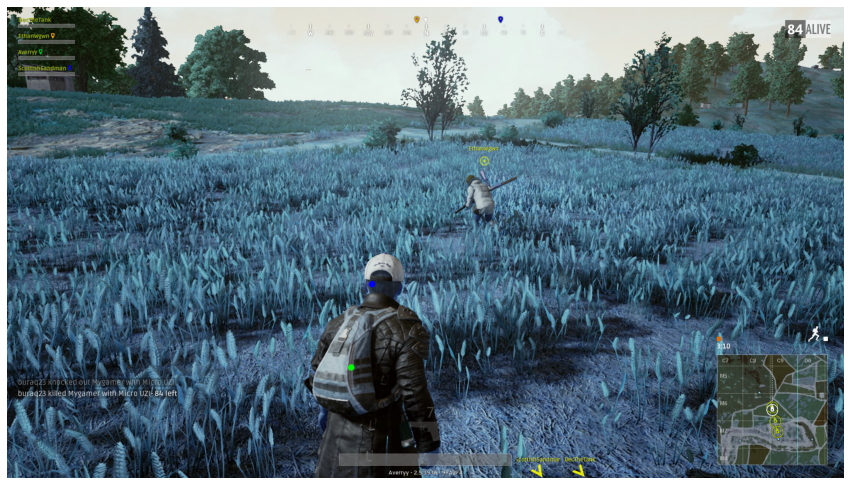

In [68]:
'''
print image for testing only, no need copy
'''
import cv2
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib

rcParams['figure.figsize'] = 15, 12

def draw_keypoints_and_boxes(heads, bodies, image):
    print(heads, bodies)
    for head in heads:
      cv2.circle(image, (int(head[0]), int(head[1])), 7, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    for body in bodies:      
      cv2.circle(image, (int(body[0]), int(body[1])),7, (0, 255,0), thickness=-1, lineType=cv2.FILLED)

    return image

def show_image(path):
    image = plt.imread(path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

image_path = os.path.join(module_dir, "screenshots/test.jpeg")
image = Image.open(image_path).convert('RGB')
orig_numpy = np.array(image, dtype=np.float32)
orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
output_image = draw_keypoints_and_boxes(heads, bodies, orig_numpy)
plt.imshow(output_image)
plt.axis('off')
plt.show()